# What is Seasonality? #

We say that a time series exhibits **seasonality** whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ViYbSxS.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Seasonal patterns in four time series.
</center></figcaption>
</figure>

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

# Seasonal Plots and Seasonal Indicators #

Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on *Trigonometry*: the article's daily views plotted over a common *weekly* period.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/bd7D4NJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>There is a clear weekly seasonal pattern in this series, higher on weekdays and falling towards the weekend.
</center></figcaption>
</figure>

### Seasonal indicators

**Seasonal indicators** are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the *Trigonometry* series will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.) : Linear regression에서 one-hot 더미 만들때, 하나는 없애는게 가장 좋은 성능

| Date       | Tuesday | Wednesday | Thursday | Friday | Saturday | Sunday |
|------------|---------|-----------|----------|--------|----------|--------|
| 2016-01-04 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-05 | 1.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-06 | 0.0     | 1.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-07 | 0.0     | 0.0       | 1.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-08 | 0.0     | 0.0       | 0.0      | 1.0    | 0.0      | 0.0    |
| 2016-01-09 | 0.0     | 0.0       | 0.0      | 0.0    | 1.0      | 0.0    |
| 2016-01-10 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 1.0    |
| 2016-01-11 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| ...        | ...     | ...       | ...      | ...    | ...      | ...    |

In [5]:

import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

# Example - Tunnel Traffic #

We'll continue once more with the *Tunnel Traffic* dataset. This hidden cell loads the data and defines two functions: `seasonal_plot` and `plot_periodogram`.

Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/hIlF5j5.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Ordinary linear regression learns the mean values at each time in the season.</center></figcaption>
</figure>

The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of `1` (*On*). Linear regression learns a baseline value `2379` for `Mon` and then adjusts by the value of whichever indicator is *On* for that day; the rest are `0` and vanish.

# Fourier Features and the Periodogram #

The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

Let's take a look at a plot for the annual season in *Trigonometry*. Notice the repetitions of various frequencies: a long up-and-down movement three times a year, short weekly movements 52 times a year, and perhaps others.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/NJcaEdI.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Annual seasonality in the <em>Wiki Trigonometry</em> series.</center></figcaption>
</figure>

It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

**Fourier features** are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/bKOjdU7.png" width=600, alt="A top figure and a bottom figure, each showing a sine curve and a cosine curve. The curves in the top plot both have frequency of once per year, while the curves in the bottom plot both have a frequency of twice per year.">
<figcaption style="textalign: center; font-style: italic"><center>The first two Fourier pairs for annual seasonality. <strong>Top: </strong>Frequency of once per year. <strong>Bottom: </strong>Frequency of twice per year.</strong></center></figcaption>
</figure>

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series. The figure illustrates how linear regression used four Fourier pairs to model the annual seasonality in the *Wiki Trigonometry* series.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/mijPhko.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center><strong>Top: </strong>Curves for four Fourier pairs, a sum of sine and cosine with regression coefficients. Each curve models a different frequency. <strong>Bottom: </strong>The sum of these curves approximates the seasonal pattern.</center></figcaption>
</figure>

Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.

### Choosing Fourier features with the Periodogram

How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The **periodogram** tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is `(a ** 2 + b ** 2) / 2`, where `a` and `b` are the coefficients of the sine and cosine at that frequency (as in the *Fourier Components* plot above).

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/PK6WEe3.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Periodogram for the <em>Wiki Trigonometry</em> series.</center></figcaption>
</figure>

From left to right, the periodogram drops off after *Quarterly*, four times a year. That was why we chose four Fourier pairs to model the annual season. The *Weekly* frequency we ignore since it's better modeled with indicators.

### Computing Fourier features (optional)

Knowing how Fourier features are computed isn't essential to using them, but if seeing the details would clarify things, the cell hidden cell below illustrates how a set of Fourier features could be derived from the index of a time series. (We'll use a library function from `statsmodels` for our applications, however.)

In [6]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

Let's take a look at seasonal plots over a week and over a year.

In [9]:
# tunnel 데이터를 복사하여 새로운 데이터프레임 X를 만듭니다.
X = tunnel.copy()

# 주 내의 일 (요일)
X["day"] = X.index.dayofweek  # x축 값 (freq)
X["week"] = X.index.to_timestamp().isocalendar().week  # 계절 주기 (period)

# 연 내의 일 (일자)
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

In [11]:
X.head(5)

,NumVehicles,day,week,dayofyear,year
Day,,,,,
2003-11-01,103536,5,<NA>,305,2003
2003-11-02,92051,6,<NA>,306,2003
2003-11-03,100795,0,<NA>,307,2003
2003-11-04,102352,1,<NA>,308,2003
2003-11-05,106569,2,<NA>,309,2003


IndexError: index -1 is out of bounds for axis 0 with size 0

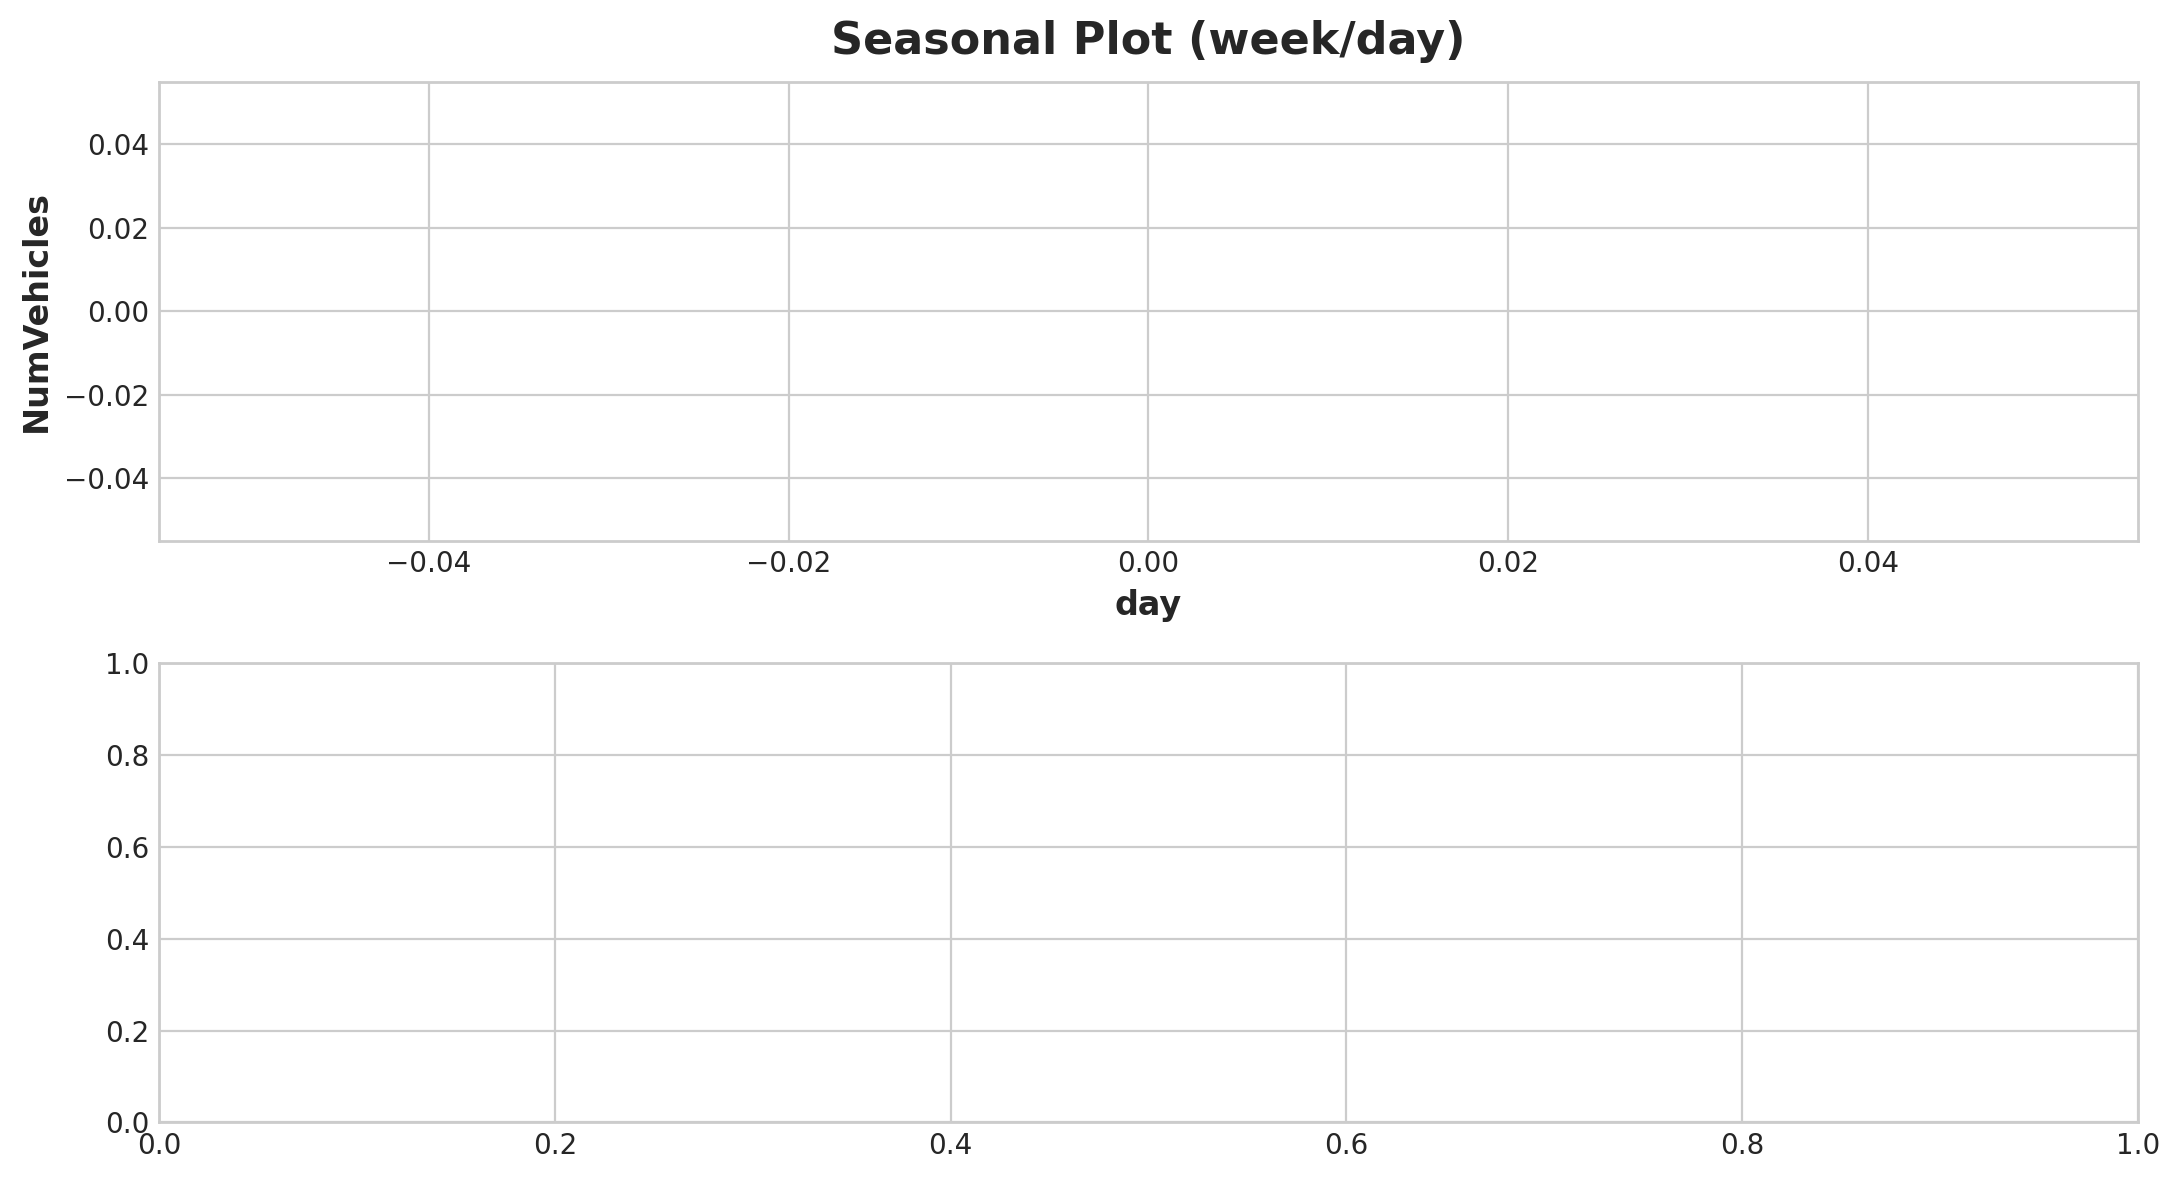

In [13]:
# 2개의 서브플롯을 생성합니다.
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))

# 주 단위 계절성을 플롯합니다.
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)

# 연 단위 계절성을 플롯합니다.
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1)

Now let's look at the periodogram:

In [ ]:
plot_periodogram(tunnel.NumVehicles);

The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between *Bimonthly (6)* and *Monthly (12)*, so let's use 10 Fourier pairs.

We'll create our seasonal features using `DeterministicProcess`, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [14]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Fourier 변환을 사용하여 연간 계절성을 나타내는 10쌍의 sin/cos 함수를 생성합니다.
fourier = CalendarFourier(freq="A", order=10)  # "A"는 연간 계절성을 의미

# DeterministicProcess 인스턴스를 생성합니다.
dp = DeterministicProcess(
    index=tunnel.index,           # 시계열 데이터의 인덱스 (날짜)
    constant=True,                # 절편(bias) 항을 추가
    order=1,                      # 1차 추세(선형 추세)
    seasonal=True,                # 주간 계절성 (주 단위 계절성 인디케이터)
    additional_terms=[fourier],   # 연간 계절성을 나타내기 위해 Fourier 변환 추가
    drop=True,                    # 다중 공선성을 피하기 위해 필요시 항을 제거
)

# `tunnel.index`에 해당하는 날짜들에 대한 특징(feature) 세트를 생성합니다.
X = dp.in_sample()


With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.

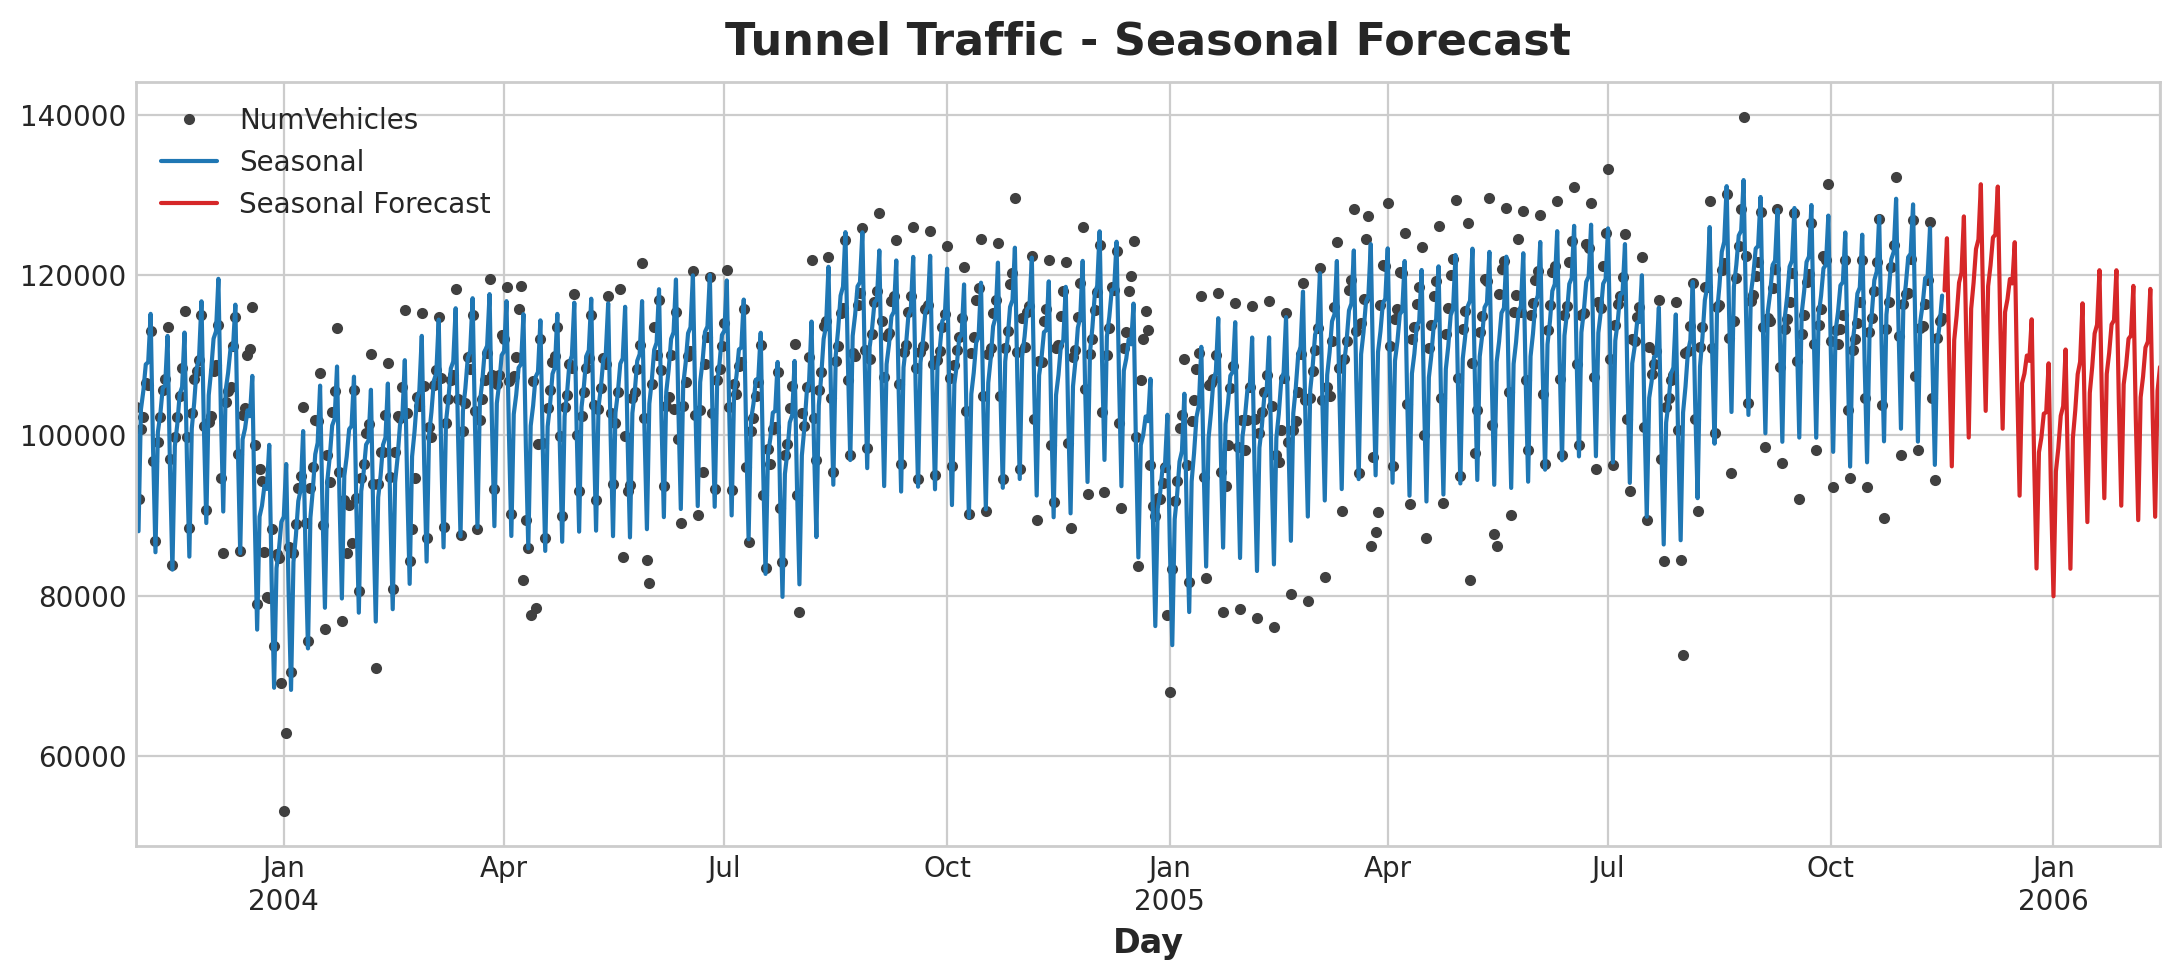

In [15]:
# 터널 데이터의 NumVehicles 열을 타겟으로 설정합니다.
y = tunnel["NumVehicles"]

# 선형 회귀 모델을 생성하고, 절편(fit_intercept)을 포함하지 않도록 설정합니다.
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)  # 모델을 학습시킵니다.

# 학습된 모델을 사용하여 예측값을 생성하고, y 인덱스를 사용하여 시리즈로 저장합니다.
y_pred = pd.Series(model.predict(X), index=y.index)

# 90일 동안의 예측을 위해 out_of_sample 메서드를 사용하여 특징(feature) 세트를 생성합니다.
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

# 실제 데이터를 플롯합니다.
ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")

# 학습된 모델의 예측값을 플롯합니다.
ax = y_pred.plot(ax=ax, label="Seasonal")

# 90일 동안의 예측값을 플롯합니다.
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')

# 범례를 추가합니다.
_ = ax.legend()

---

There's still more we can do with time series to improve our forecasts. In the next lesson, we'll learn how to use time series themselves as a features. Using time series as inputs to a forecast lets us model the another component often found in series: *cycles*.

# Your Turn #

[**Create seasonal features for Store Sales**](https://www.kaggle.com/kernels/fork/19615991) and extend these techniques to capturing holiday effects.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*